# Part 4: Recurrent Neural Networks

<hr>

In [1]:
import importlib
import gensim
import nltk
import json
import numpy as np
from materials.code import utils
importlib.reload(utils)
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torch import nn

# IMPORT SOME BASIC TOOLS:
from pprint import pprint
import pyarrow

<br><br>
### Introduction
The problem with `doc2vec` is that it completely ignores the order of the words in the text when computing the document representations. In reality, the sequential order in which words appear can have an important consequence for their combined meaning. Consider, for example, if we were interested in classifying a movie review with the tokens `well`, `done`, `not`, and `bad`. It is not just the tokens, but also their order, that would be indicative of the class:

> **Well done, not bad.** vs. **done bad, not well.** 

We need a way to account for the sequential order of words when we are performing our modeling - this is where Recurrent Neural Networks (RNNs) come into play. As we discussed in the lectures, RNNs (and their derivatives) provide a way to account for the sequential relationships between words by retaining some information about previous elements in a sequence, when considering a given element. Please note that in this tutorial, we'll mainly be covering the practical elements of how to build RNN-style networks in Pytorch. If you are interested in learning how to build a Recurrent Neural Network from scratch there is an excellent [publicly available tutorial here](https://github.com/pangolulu/rnn-from-scratch). 


### Activation Functions
Before we dive into building an RNN, recall that the motivating purpose of the $sigmoid$ function in the earlier tutorials was to "squeeze" the values of our linear functions within a range of interest. For instance, the range of 0-1. The sigmoid accomplished this nicely, but there is nothing that *requires us* to use the sigmoid is we want to restrict our output between a numerical range; indeed, there are many other functions that can accomplish this. One obvious way is to simply "rectify" our function's output value anytime it's out of range. For instance, if we have a function $f(x)$ that we want to bound in the range of 0-1, then we could set all values above 1 to 1, and all less than 0 to 0. If the $x$ in our $f(x)$ was generated by a linear function of some kind, then we would call $f(x)$ a rectified linear unit (or $ReLU$, for short). 

Both the $ReLU$ and the $sigmoid$ have outputs that are non-negative. This is fine for modeling probabilities, but there could be circumstances where we want our function to provide both positive and negative numbers; for instance, values between between -1 and 1. This can be accomplished using the $tanh$ function (or also by shifting a scaling a sigmoid or ReLU!). In the context of Neural networks, the $sigmoid$, the $ReLU$ and the $tanh$ are called **activation functions**. Let's code up each of these functions and plot them below to solidify your intuition:

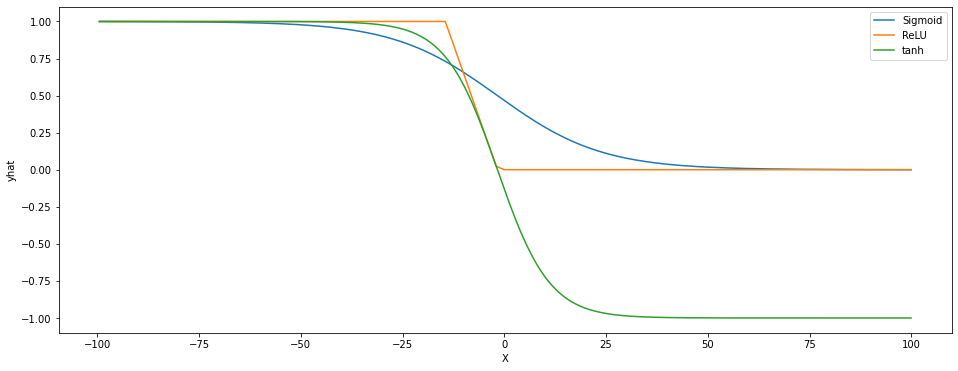

In [367]:
plt.figure(figsize = (16,6))

#-------------------------------------------------
# A Linear Function
#-------------------------------------------------
def linear(X,beta):
    return np.dot(X, beta[1:]) + beta[0]

#-------------------------------------------------
# A Sigmoid function
#-------------------------------------------------
def sigmoid(X):
    return 1/(1 + np.exp(-(X)))

#-------------------------------------------------
# A Recitfied Linear Unit
#-------------------------------------------------
def relu(X):
    # Rectify activations below 0
    X = np.maximum(np.zeros(np.shape(X)),X)
    
    #Recitfy activations above 1
    X = np.minimum(np.ones(np.shape(X)),X)

    return X

#-------------------------------------------------
# A Tanh 
#-------------------------------------------------
def tanh(X):
    t  =(np.exp(X)-np.exp(-X))/(np.exp(X)+np.exp(-X))
    return t

#-------------------------------------------------
# Compute yhat, given X and paramters beta
#-------------------------------------------------
X          = np.random.uniform(low= -100, high = 100, size = (1000,1))
beta       = np.random.normal(size = (np.shape(X)[1] + 1,1))
yhat_sig   = sigmoid(linear(X,beta))
yhat_relu  = relu(linear(X,beta))
yhat_tanh  = tanh(linear(X,beta))

#-------------------------------------------------
# Plot
#-------------------------------------------------
index  = np.argsort(X[:,0])
X, yhat_sig, yhat_relu, yhat_tanh = X[index,:], yhat_sig[index,:], yhat_relu[index,:], yhat_tanh[index,:]
plt.plot(X,yhat_sig,label="Sigmoid")
plt.plot(X,yhat_relu,label="ReLU")
plt.plot(X,yhat_tanh,label="tanh")
plt.xlabel('X');plt.ylabel('yhat')
plt.legend()
plt.show()

While the $sigmoid$, $ReLU$ and $tanh$ are among the most common activation functions, there are others too! You can learn more about the varieties of activation function, and their pros/cons [here](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html).

## An LSTM in PyTorch


The trickiest part of using PyTorch (in my opinion) is getting used to how to format your data before passing it to the model. In the case of RNNs there are special formatting considerations that result from the fact that we have sequences of multiple lengths we need to classify. The best way to understand this is to go through a simple example.

### Step 1: Formatting Vocabualry:
To begin, let's import the vocabulary we generated when batch processing the larger Rotten Tomatoes dataset from part 3 using a helper function I've written in `utils.prepareVocabulary`:

In [242]:
importlib.reload(utils)
vocabulary = utils.prepareVocabulary(vocab_json = 'materials/data/rt_reviews/vocabulary.json', remove_less_than = 25)

print('Number of words:', len(vocabulary))

Adding tokens for padding <pad> at position [0], and missing <missing> at position [1]
Number of words: 19495


<br> The helper function puts the vocabulary in alphabetical order, and adds two new special "words" `<pad>` and `<missing>` that I will use to denote padding and missing words respectively; the `<missing>` token will replace any tokens that do not show up in the vocabulary, and the `<pad>` will be appended to the end of shorter sentences in our dataset to ensure that all sentences technically have the same number of "words". Note that the helper function allows us to remove words as a function of their frequency through the `remove_less_than` variable. Our frequency cut-off of 25 removes about 80% of the words, but 20,000 is still a pretty significant number!

### Step 2: One Hot Coding
To build a model, we need a way of representing our text numerically. When we were doing sentence-level processing we used bag-of-words, when we're doing word level-processing we use [one-hot-coding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/). Let's go through an example with some very simple data:



In [244]:
#----------------------------------------------------
# Some Sample sentences
#----------------------------------------------------
sentences  = ['The move was very good.',                        
              'the movie was bad someverynonsensicalword',     
              'not good!']                                     


pprint(sentences)
print('\n')

['The move was very good.',
 'the movie was bad someverynonsensicalword',
 'not good!']




<br> As usually, let's start by tokenizing the text (using `nltk`) and doing some very simple pre-processing (i.e. converting all text to lowercase).

In [245]:
#----------------------------------------------------
# Tokenize the sentences
#----------------------------------------------------
for i,sentence in enumerate(sentences):
    sentences[i] = nltk.word_tokenize(gensim.utils.to_unicode(sentence.lower()))
    
pprint(sentences)
print('\n')

[['the', 'move', 'was', 'very', 'good', '.'],
 ['the', 'movie', 'was', 'bad', 'someverynonsensicalword'],
 ['not', 'good', '!']]




<br>Now that we have the tokens, we can one-hot encode the sentences; that is, we will represent each word as it's index in the vocabulary. I've written a helper function for this in `utils.onehot`

In [191]:
#----------------------------------------------------
# One hot code
#----------------------------------------------------
onehot_sentences = utils.onehot(list_of_tokenized_sentences = sentences, vocabulary = vocabulary)

pprint(onehot_sentences)
print('\n')

[[17308, 11292, 18830, 18566, 7499, 61],
 [17308, 11298, 18830, 1509, 1],
 [11733, 7499, 2]]




Notice that each token that had a match in the vocabulary was converted to it's index in the vocabulary; for instance, the word `the` is the 17,308th word in the vocabulary. Also note that when a word does not show up in the vocabulary - such as `someverynonsensicalword` - it is assigned an index of 1. this is because our `utils.prepareVocabulary` helper function from earlier added a special  token `<missing>` as a catch-all for any missing tokens in the text, and assigned it an index of 1. 


### Step 3: Padding and Tensor Preparation
As we discussed in the `Doc2Vec` portion of the tutorial, most models (including networks) will expect a fixed length input tensor. But in their current state, each of our simple sentences are different lengths because each has a different number of words! One way to handle this is to pad the shorter sentences with the `<pad>` token until all the sentences are the same length. Recall that the `utils.prepareVocabulary` helper function from earlier denoted a special token `<pad>` for this exact purpose, and assigned it at index 0. Hence, I can zero-pad the tensors to indicate the padding. 

In [249]:
#----------------------------------------------------
# Pad sentences so they are the same length
#----------------------------------------------------
seq_lengths = torch.LongTensor(list(map(len, onehot_sentences)))
print('sequence lengths:',seq_lengths)

seq_tensor = Variable(torch.zeros((len(onehot_sentences), seq_lengths.max()))).long()
for idx, (seq, seqlen) in enumerate(zip(onehot_sentences, seq_lengths)):
    seq_tensor[idx, :seqlen] = torch.LongTensor(seq)
    
print(seq_tensor)   

sequence lengths: tensor([6, 5, 3])
tensor([[17308, 11292, 18830, 18566,  7499,    61],
        [17308, 11298, 18830,  1509,     1,     0],
        [11733,  7499,     2,     0,     0,     0]])


<br> And now all of our sentences are the same length, excellent. Note that the above code block also took care of casting the sentences to tensors but there is one remaining step to use these tensors as inputs to PyTorch - we need to transpose them.

In [250]:
# Note, must be transposed or Pytorch complains.
seq_tensor = seq_tensor.transpose(0,1)
print(seq_tensor)

tensor([[17308, 17308, 11733],
        [11292, 11298,  7499],
        [18830, 18830,     2],
        [18566,  1509,     0],
        [ 7499,     1,     0],
        [   61,     0,     0]])


<br>Why do we need to transpose them? There is no special reason other than Pytorch expects it that way by default. So, now we finally have we have everything in the right format for passing to a PyTorch neural network. Let's combine all these transformation steps of the data needed to convert the raw sentences to tensors, along with the `utils.getBatch` function from part 3, so that we have a end-to-end way to get batches of properly formatted tensor data from our larger dataset!

In [251]:
def getTensorBatch(data_path, batch_number, batch_size, random_seed, max_sequence_length):
    print(data_path)
    #-----------------------------------------------------
    # Import a batch of data
    #-----------------------------------------------------
    data, end_flag = utils.getBatch(data_path,  batch_number, batch_size, random_seed)

    #-----------------------------------------------------
    # Unpack the JSON
    #-----------------------------------------------------
    reviews,freshness  = [], []
    for row in data:
        reviews.append(row['Review'])
        freshness.append(row['Freshness'])
    freshness = [float(x) for x in freshness]

    #-----------------------------------------------------
    # Format the outcome tensor - y
    #-----------------------------------------------------
    y = torch.tensor(freshness)
    y = y.to(torch.float)
    y = y.view(np.shape(y)[0] , 1)

    #-----------------------------------------------------
    # Format the input tensor - X
    #-----------------------------------------------------
    for i,sentence in enumerate(reviews):
        reviews[i] = nltk.word_tokenize(gensim.utils.to_unicode(sentence.lower()))
    onehot_sentences = utils.onehot(list_of_tokenized_sentences = reviews, vocabulary = vocabulary)

    seq_lengths = torch.LongTensor(list(map(len, onehot_sentences)))
    seq_tensor  = Variable(torch.zeros((len(onehot_sentences), max_sequence_length))).long()

    for idx, (seq, seqlen) in enumerate(zip(onehot_sentences, seq_lengths)):
        seq_tensor[idx, :seqlen] = torch.LongTensor(seq)
    seq_tensor = seq_tensor.transpose(0,1)

    return seq_tensor, seq_lengths, y, end_flag

<br><br>Finally, let's test out our `getTensorBatch` function above works by fetching a small batch of data:

In [257]:
data_path     = 'materials/data/rt_reviews/train_re_reviews.jsonl'
X, X_lengths, y, end_flag = getTensorBatch(data_path, batch_number = 1, batch_size = 3, random_seed = 1, max_sequence_length=38)

print('X:',X)
print('\n')
print('y:',y)


materials/data/rt_reviews/train_re_reviews.jsonl
X: tensor([[11253, 17374,  7985],
        [11896,  9286,   305],
        [17308,   305, 10282],
        [ 9458, 12366, 17547],
        [14369,   295, 14880],
        [ 1179, 18530,   340],
        [17308,  9286,   859],
        [  652, 11436,    38],
        [11896,     1,  5826],
        [17308,     1,   918],
        [ 2931, 19400,  2836],
        [  918,  8620,  4198],
        [  897, 17340,    57],
        [12170,  7823,   918],
        [ 4623,  1722,  9301],
        [11965, 11222, 17208],
        [15732, 11896,   305],
        [ 8505,  9301, 12938],
        [10472,    57, 16509],
        [17374,   918,  8787],
        [  305,  8620, 17308],
        [14542, 17305, 13319],
        [  918, 11222,    61],
        [15788,  7823,     8],
        [    1,  1722,     0],
        [11896,   305,     0],
        [  305, 10174,     0],
        [11298, 19100,     0],
        [   61, 12046,     0],
        [  301,     1,     0],
        [ 7085,   

<br><br>Note that the `getTensorBatch` function has as an input parameter the `max_sequence_length` - which indicates the length of the longest sequence in our dataset. I've placed this as `38` just for illustrative purposes, but you would need to identify the actual length from the data itself. 

### Step 4: Pre-trained Embeddings
The one-hot coded "vectors" are not really vectors yet - they are still just indicies! In order to use them for machine learning, we'll need to convert them to proper vectors. Instead of training these vectors from scratch, We can use pre-trained embeddings as the "starting point" for our word vectors. The model will be able to tune these embeddings to be best suited for the task. In the earlier portions of this tutorial, we used `gensim` to train our `word2vec` and `doc2vec` models. `Pytorch` has it's own embedding functionality and, importantly, the embeddings can be combined with other layers directly to train models end-to-end. Let's convert the `glove` embeddings into `tensor` format using my helper function `utils.loadEmbeddings`:

In [258]:
# Load the Glove embeddings and arrange the vector columns according to the word indicies
importlib.reload(utils)
glove_embeddings = utils.loadEmbeddings(path          = 'materials/data/glove.6B.50d.txt', 
                                        vocabulary    = vocabulary, 
                                        embedding_dim = 50)

<br>The helper function sorts the vectors in the same order as the vocabulary and casts it to tensor format. That is, the one-hot indicies from above can be converted into vectors in the embedding matrix! Here's an example with the word `apple`:

In [368]:
# Get the index of the word apple
apple_index = vocabulary.index('apple')

# Get the vector at that index
print(glove_embeddings[apple_index])

tensor([ 0.5204, -0.8314,  0.4996,  1.2893,  0.1151,  0.0575, -1.3753, -0.9731,
         0.1835,  0.4767, -0.1511,  0.3553,  0.2591, -0.7786,  0.5218,  0.4769,
        -1.4251,  0.8580,  0.5982, -1.0903,  0.3357, -0.6089,  0.4174,  0.2157,
        -0.0742, -0.5822, -0.4502,  0.1725,  0.1645, -0.3841,  2.3283, -0.6668,
        -0.5818,  0.7439,  0.0950, -0.4787, -0.8459,  0.3870,  0.2369, -1.5523,
         0.6480, -0.1652, -1.4719, -0.1622,  0.7986,  0.9739,  0.4003, -0.2191,
        -0.3094,  0.2658])


<br><br> Now that our data (the hard part) is ready to go - we can finally specify the Neural Network

### Step 5: Model Specification
Let's specify the RNN in torch. I've included ample comments within this function in an effort to explain the logic. 

In [355]:
import torch.nn as nn

class classifier(nn.Module):
    
    #define all the layers used in model
    
    # Whenever an instance of a class is created, init function is automatically invoked. 
    # We will define all the layers that we will be using in the model
    def __init__(self, vocab_size, embedding_dim, embeddings, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        
        super().__init__()          
        
        #embedding layer
        self.embedding        = nn.Embedding(vocab_size, embedding_dim)  # This is a simple lookup table that turns the one-hot encodings into a vector - just like word2vec!
        self.embedding.weight = nn.Parameter(embeddings)                 # pretrained_weight is a numpy matrix of shape (num_embeddings, embedding_dim)
        
        # lstm layer
        self.lstm = nn.LSTM(embedding_dim,                        # Dimension of input
                            hidden_dim,                           # Number of hidden nodes
                            num_layers    = n_layers,             # Number of layers to be stacked
                            bidirectional = bidirectional,        # If True, uses a Bi directional LSTM
                            dropout       = dropout               # Introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout.
                           )
        
        # dense layer
        multiplier = 1 if bidirectional == False else 2
        self.fc    = nn.Linear(hidden_dim * multiplier, output_dim)
        
        # final activation function
        self.act = nn.Sigmoid()
    
    # This is where we chain together to layers to get the output we want
    def forward(self, text, text_lengths, bidirectional):
        
        # 1. Embedding: is used to convert the one-hot word representations into their
        #               Word vector representations. 
        embedded = self.embedding(text)
      
        # 2. Pack padding: tells the network to ignore the inputs that are `<pad>`. 
        #                  so that the outputs we generate are not influenced by the `<pad>` tokens; 
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, enforce_sorted=False)
        
        # 3. LSTM: is a variant of RNN that captures long term dependencies.
        #          Following some important parameters of LSTM that you should be familiar with. Given below are the parameters of this layer:Run the LSTM layer
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
      
        # 4. Concatenate: the final forward and backward hidden state
        hidden = hidden[-1,:,:] if bidirectional == False else torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        
        # 5. Linear: Connect to a densely connected linear layer
        dense_outputs =self.fc(hidden)
            

        # 6. ACtivation: Pass value to our sigmoid 
        outputs=self.act(dense_outputs)
        
        return outputs

<br> Now that the model is specified, we can choose the settings of the hyper-parameters, optimizer and criterion:

In [369]:
importlib.reload(utils)
import torch.optim as optim

#-------------------------------------------------
# setting hyperparameters
#-------------------------------------------------
data_path          = 'materials/data/rt_reviews/train_re_reviews.jsonl'
num_hidden_nodes   = 32
num_output_nodes   = 1
num_layers         = 2
bidirectional      = False
dropout            = 0.2
size_of_vocab      = len(vocabulary)
embeddings         = glove_embeddings
embedding_dim      = glove_embeddings.size()[1]

#-------------------------------------------------
# Instantiate the model
#-------------------------------------------------
model = classifier(size_of_vocab, embedding_dim,embeddings,num_hidden_nodes,
                   num_output_nodes, num_layers, bidirectional = bidirectional, dropout = dropout)

#-------------------------------------------------
# Set the optimizer
#-------------------------------------------------
optimizer       = optim.Adam(model.parameters())

#-------------------------------------------------
# Set the loss criterion
#-------------------------------------------------
criterion       = nn.BCELoss()

#-------------------------------------------------
# Optionally, push to GPU, if available
#-------------------------------------------------
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model     = model.to(device)
criterion = criterion.to(device)


<br><br>One thing that I like to do to make sure my model is sensible is to print out the architecture:

In [370]:
#architecture
print(model)

classifier(
  (embedding): Embedding(19495, 50)
  (lstm): LSTM(50, 32, num_layers=2, dropout=0.2)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (act): Sigmoid()
)


<br>Notice that the model takes in a 19,495 vector (these are the "one-hot" vectors) and converts it to a 50 dimensional representation (the glove embeddings). The model passes this 50 dimensional vector to the LSTM which outputs a 32 dimensional vector that is passed to a linear layer, and finally to a sigmoid. We can check how many parameters the model has too:

In [371]:
importlib.reload(utils)
print(f'The model has {utils.count_parameters(model):,} trainable parameters')

The model has 993,983 trainable parameters


<br> Nearly a million! Now, as a final check before training, let's make sure that that the model works when we put data in. 

In [363]:
# Import a batch of data
data_path     = 'materials/data/rt_reviews/train_re_reviews.jsonl'
X, X_lengths, y, end_flag = getTensorBatch(data_path, 
                                           batch_number        = 1, 
                                           batch_size          = 3,
                                           random_seed         = 1, 
                                           max_sequence_length = 50)

# Make sure that the model works by passing data into it, and seeing what comes out.
predictions = model(X, X_lengths, bidirectional).squeeze()        


print(predictions)

materials/data/rt_reviews/train_re_reviews.jsonl
tensor([0.5142, 0.5090, 0.5127], grad_fn=<SqueezeBackward0>)


<br> We got three tensors back, one for each data-point.

<hr> 

## Learning Exercise 4: 
#### Worth 1/5 Points
#### A. Batch Training the network
Write a function to `train` the LSTM `classifier` specified in the tutorial, above. Note that the procedure to train the model here will be almost identical to what we did in Homework 3. More specifically, your train function should allow you to:

1. Train the model for multiple `epochs`, 
2. Break each epoch's training into multiple `batches`, 
3. generate your `predictions` (i.e. `model(X, X_lengths).squeeze()`) on each batch,
4. compute the loss using the batch predictions and the batch labels (`y`).
5. back-propagate the batch loss and compute gradients
6. Update the model parameters
8. Stop training when the validation set performance stops improving 

Prove that your train function works by training the `classifier` for several batches and plotting the loss of the model on the training and validation sets. You are welcome to tweak the settings of the hyper-parameters, add or subtract layers, etc. as long as you use an LSTM 

**Please Note:** In all likelihood your personal machines will not have the computational might (or time) required to train a perfect LSTM model with 1M parameters. You are not required to build a high-performance model here, rather, I just want to see that you can train and evaluate the model *in batches*. While it is not required, you can use the [MSU High Performance Computing Cluster](https://icer.msu.edu/users/getting-startedhttps://icer.msu.edu/users/getting-started) if you want to explore a greater variety of network settings, or improve the performance of the networks by exploring the hyper-parameters more carefully.

In [239]:
################################################################################
# INSERT YOUR CODE HERE
# DO NOT FORGET TO PRINT YOUR MEANINGFUL RESULTS TO THE SCREEN.
################################################################################

<span style="color:red"> INSERT AN INTERPRETATION OF YOUR RESULTS HERE </span>

<hr>
<h1><span style="color:red"> Self Assessment </span></h1>
Please provide an assessment of how successfully you accomplished the learning exercises in this assignment according to the instruction provided; do not assign yourself points for effort. This self assessment will be used as a starting point when I grade your assignments. Please note that if you over-estimate your grade on a given learning exercise, you will face a 50% penalty on the total points granted for that exercise. If you underestimate your grade, there will be no penalty.

* Learning Exercise: 
    * <span style="color:red">X</span>/1 points